I have download the RECs 2009 data from eia's website: https://www.eia.gov/consumption/residential/data/2009/index.php?view=microdata

Please read the  _**Notes**_  and _**Observations**_  throughout the Notebook to understand the approach and flow

##   REC 2009_DataViz

The code flow:
 1. Import data and libraries
     1.1 Defining Local Functions
     1.2 Load Data
 2. Raw Data Exploration
     2.1 View class group sizes
     2.2 View distributions of feature values
 3. Dimensionality Reduction
     3.1 Check for degeneracy and compressability (using scipy svd method)
     3.2 Feature Reduction (using scikit-learn TruncatedSVD method)
 4. Visualisation of dataset with reduced dimensionality
     4.1 Pairs Plots
     4.2 3D Scatterplot
 5. t-SNE Reduction and Visualisation
     5.1 Observe scaling on basic t-SNE
     5.2 Calculate t-SNE representation
     5.3 View t-SNE representation with and without class labels
 6. In Review


In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
import re

from collections import OrderedDict
from time import time
import sqlite3       

from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd   
from scipy import stats
from sklearn.decomposition import TruncatedSVD

from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

from IPython.html.widgets import interactive, fixed

sns.set(style="darkgrid", palette="muted")
pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 10,6
np.random.seed(0)

In [2]:
cnx = sqlite3.connect('RECs_data/recs2009_public.db')

### Defining Local Functions for 3D Scatter Plot 


In [3]:
def scatter_3D(A, elevation=30, azimuth=120):
    
    maxpts=1000
    fig = plt.figure(1, figsize=(9, 9))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=elevation, azim=azimuth)
    ax.set_xlabel('component 0')
    ax.set_ylabel('component 1')
    ax.set_zlabel('component 2')

    # plot subset of points
    rndpts = np.sort(np.random.choice(A.shape[0], min(maxpts,A.shape[0]), replace=False))
    coloridx = np.unique(A.iloc[rndpts]['TYPEHUQ'], return_inverse=True)
    colors = coloridx[1] / len(coloridx[0])   
    
    sp = ax.scatter(A.iloc[rndpts,0], A.iloc[rndpts,1], A.iloc[rndpts,2]
               ,c=colors, cmap="jet", marker='o', alpha=0.6
               ,s=50, linewidths=0.8, edgecolor='#BBBBBB')

    plt.show()

### Load Data

In [4]:
df_raw = pd.read_csv('RECs_data/recs2009_public.csv')
print(df_raw.shape)
df_raw.head()

(12083, 931)


,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEEL,KAVALNG,PERIODNG,SCALENG,PERIODLP,SCALELP,PERIODFO,SCALEFO,PERIODKR,SCALEKER
0,1,2,4,12,2,2471.679705,4742,1080,4953,1271,...,0,-2,-2,-2,-2,-2,-2,-2,-2,-2
1,2,4,10,26,2,8599.172010,2662,199,2688,143,...,0,1,1,0,-2,-2,-2,-2,-2,-2
2,3,1,1,1,5,8969.915921,6233,505,5741,829,...,0,3,5,3,-2,-2,-2,-2,-2,-2
3,4,2,3,7,2,18003.639600,6034,672,5781,868,...,3,3,5,3,-2,-2,-2,-2,-2,-2
4,5,1,1,1,3,5999.605242,5388,702,5313,797,...,0,1,1,0,-2,-2,-2,-2,-2,-2


There are ~360 features in the dataset which are just imputation flags for the other features. They are thus creating degeneracy in the data. By a quick visual inspection, we have determined that the names of all the imputation flag variables start with the letter 'Z'. So now we are gonig to remove those features from our dataset. 
#### Observe
   + Original raw dataset shape (12083, 931)
   + After discarding the features, the shape of the dataset (12083, 572)

In [5]:
Discarded_feature = [x for x in df_raw.columns if x.startswith('Z')] 
df = df_raw[[c for c in df_raw.columns.values.tolist() if c not in Discarded_feature]]
df.shape

(12083, 572)

#### Now writing this processed dataframe to DB for easier loading later


In [6]:
df.to_sql('df_clean', cnx, if_exists='replace', index=None)

## Data Desciption 

    Our data is the 2009 RECS (Residential Energy Consumption Survey) data. 

+ This is a set of 12,083 households selected at random using a complex multistage, area-probability sample design. This sample represents 113.6 million U.S. households.

+ Each household is described by 931 features including type of household, number of appliances, energy consumption in BTU.  

TYPEHUQ is one of the features we are choosing to classify the data. There are 5 different types of housing units in the dataset:
    
    1- Mobile Home
    2- Single-Family Detached
    3- Single-Family Attached
    4- Apartment in Building with 2 - 4 Units
    5- Apartment in Building with 5+ Units

    
    
> _**Note:**_ All but 9 features are numeric but are on different scales

9 Character features are:

    Unique identifier for each respondent
    Housing unit in Census Metropolitan Statistical Area or Micropolitan Statistical Area
    Housing unit classified as urban or rural by Census
    Imputation flag for TOTSQFT
    Imputation flag for TOTSQFT_EN
    Imputation flag for TOTHSQFT
    Imputation flag for TOTUSQFT
    Imputation flag for TOTCSQFT
    Imputation flag for TOTUCSQFT

Will be eventually remove them from our analysis.   
    

In [7]:
df = pd.read_sql('select * from df_clean', cnx)

### View class group sizes

#### Let's get a feel of the data by determining how many houses belong to each "Type of Housing Unit" ? 

> _**Note:**_ We have chosen to understand the impact of "type of housing unit". Which basically means that we are asking the question: is there a partical pattern across features, which is characterized by the type of housing unit?

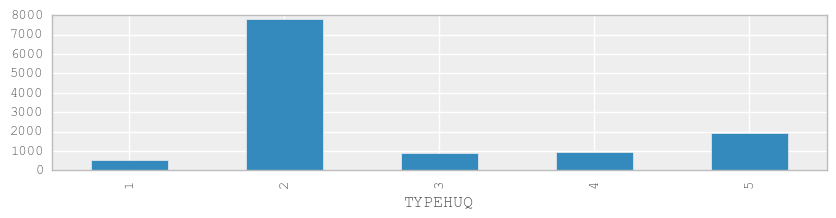

In [8]:
ax = df.groupby('TYPEHUQ').size().plot(kind='bar', figsize=(10,2))

##### **Observe:**
+ The classes are heavility skewed, with TYPEHUQ 2 (Single family-detached), being most of the houses
+ Any useful visualisation will have to be good at separating and showing the smaller classes of TYPEHUQ 1, 3 and 4.

## View distributions of Independent variables (also called feature values)

We will determine 21 basic features from the dataset (based on our intution) and create a simple facetted boxplot visualisation of their distributions, showing the values at different scales.

Basically, this is a summarised view of the TYPEHUQ classifications. This will show us how houses of different types TYPEHUQs classifications cluster together.

#### Basic features:
   + HDD65 Heating degree days in 2009, base temperature 65F
   + CDD65	Cooling degree days in 2009, base temperature 65F
   + WALLTYPE	Major outside wall material
   + BEDROOMS	Number of bedrooms
   + TOTROOMS	Total number of rooms in the housing unit
   + STOVEN	Number of stoves (one appliance with cooktop and an oven)
   + STOVEFUEL	Fuel used by most-used separate cooktop
   + AMTMICRO	Microwave usage
   + AGERFRI1	Age of most-used refrigerator
   + ESFRIG	Energy Star most-used refrigerator
   + HEATHOME	Space heating equipment used
   + EQUIPAGE	Age of main space heating equipment
   + AUTOHEATNITE	Programmable thermostat lowers temperature at night
   + AUTOHEATDAY	Programmable thermostat lowers temperature during the day
   + TEMPGONE	Temperature when no on is home during the day (winter)
   + BTUNGSPH	Natural Gas usage for space heating, in thousand BTU, 2009
   + TOTALBTUCOL	Total usage for air conditioning, in thousand BTU, 2009
   + NHSLDMEM	Number of household members
   + EMPLOYHH	Employment status of householder
   + AGEAUD	Year of home energy audit
   + WINDOWS	Number of windows in heated areas


   





   










   






In [9]:
basic = ['HDD65','CDD65','WALLTYPE','BEDROOMS','TOTROOMS','STOVEN','STOVEFUEL','AMTMICRO','AGERFRI1','ESFRIG',
         'HEATHOME','EQUIPAGE','AUTOHEATNITE','AUTOHEATDAY','TEMPGONE','BTUNGSPH','TOTALBTUCOL',
         'NHSLDMEM','EMPLOYHH','AGEAUD','WINDOWS']

idxdict = OrderedDict()
for b in basic:
    idxdict[b]=[b]

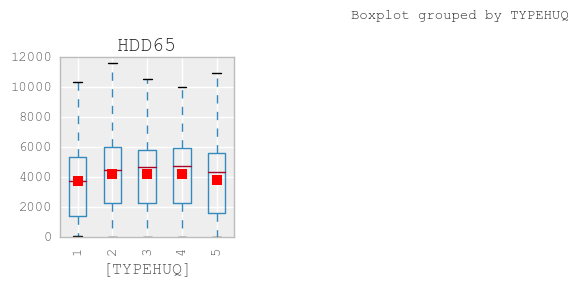

In [10]:
def plot_raw_vals(df, k):
    v = idxdict[k]
    dfg = pd.concat((df[['TYPEHUQ']],df[v]), axis=1)
    ax = dfg.boxplot(by='TYPEHUQ', layout=(2,4), figsize=(10,6)
                    ,showfliers=False, showmeans=True, rot=90)

interactive(plot_raw_vals, df=fixed(df), k=basic)

##### Observe:
+ We can select different feature using the dropdown and see differences in the TYPEHUQ Classifications. 
+ However, it's really hard to visualise the differences between household types classifications across all the 572 features!
+ Let's interprete the plots by taking first basic feature as an example. HDD65: Heating degree days in 2009, base temperature 65F (defined in the note below) is the first feature. The boxplot shows that TYPEHUQ 3 houses are located in the warmer parts of the country. But it's hard to state how different are all the other basic features and how does that impact the energy usage in the houses.

> Clearly we can do better than this for visualization.

_**Note:**_ Heating degree days are defined relative to a base temperature—the outside temperature above which a building needs no heating. One HDD means that the temperature conditions outside the building were equivalent to being below a defined threshold comfort temperature inside the building by one degree for one day. Thus heat has to be provided inside the building to maintain thermal comfort.Heating degree days are defined relative to a base temperature—the outside temperature above which a building needs no heating. 



---

---

# Dimensionality Reduction (Feature Reduction)

We want to reduce the dimensionality of the problem to make it more manageable, but at the same time we want to preserve as much information as possible. As a preprocessing step, let's start with normalizing the feature values so they are all in range[0,1] - this makes comparisons simpler and allows next steps for Singular Value Decomposition.

### Normalize

We are going to remove the following two features in order to convert the whole data into numeric values. These are the only three features left in our dataset with string/character values. Otherwise, they are going to cause trouble in implementing other functions!

 + METROMICRO	Housing unit in Census Metropolitan Statistical Area or Micropolitan Statistical Area
 + UR	Housing unit classified as urban or rural by Census
 + DOEID   Unique identifier for each respondent

We would also like to make sure that there are no blanks in our dataset, if so then we have to fill them with zero.

In [11]:
del df['METROMICRO']
del df['UR']
del df['DOEID']

#Replacing NaN values in the dataset with 0 so that the standardization and normalization functions do not choke
df.fillna(0,inplace=True) 

Normalization/Standardization: This step is very important when dealing with parameters of different units and scales. All parameters should have the same scale for a fair comparison between them because some data mining techniques use the Euclidean distance. Two methods well methods for rescaling data are:
    + Normalization - scales all numeric variables in the range [0,1]. 
    + Standardization - transforms the data to have zero mean and unit variance. 
There are drawbacks associated with both the methods:
    + If outliers exist in the dataset then normalizing the data will certainly scale the “normal” data to a very small interval. Generally, most of data sets have outliers!
    + When using standardization, the new data aren’t bounded (unlike normalization).

__*Note:*__ we are removing the outliers in the next step for overcoming the above mentioned drawback with normalization

In [12]:
for c in df.columns:
    df_new = df[np.abs(df[c]-df[c].mean())<=(3*df[c].std())]
df_new.head()

,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,Climate_Region_Pub,...,SCALEEL,KAVALNG,PERIODNG,SCALENG,PERIODLP,SCALELP,PERIODFO,SCALEFO,PERIODKR,SCALEKER
0,2,4,12,2,2471.679705,4742,1080,4953,1271,4,...,0,-2,-2,-2,-2,-2,-2,-2,-2,-2
1,4,10,26,2,8599.172010,2662,199,2688,143,5,...,0,1,1,0,-2,-2,-2,-2,-2,-2
2,1,1,1,5,8969.915921,6233,505,5741,829,1,...,0,3,5,3,-2,-2,-2,-2,-2,-2
3,2,3,7,2,18003.639600,6034,672,5781,868,1,...,3,3,5,3,-2,-2,-2,-2,-2,-2
4,1,1,1,3,5999.605242,5388,702,5313,797,1,...,0,1,1,0,-2,-2,-2,-2,-2,-2


In [13]:
df_normalized=df
colNum=1
totalCols=len(df.columns)
for col in df.columns:
    minOfCol=df[col].min()
    maxOfCol=df[col].max()
    df_normalized[col]=(df_normalized[col]-minOfCol)/(maxOfCol-minOfCol)
    #print("Normalized column {} of {}".format(colNum,totalCols))
    colNum=colNum+1

In [14]:
df_normalized.head()
df.fillna(0,inplace=True) 
df_normalized.head()

,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,Climate_Region_Pub,...,SCALEEL,KAVALNG,PERIODNG,SCALENG,PERIODLP,SCALELP,PERIODFO,SCALEFO,PERIODKR,SCALEKER
0,0.333333,0.333333,0.423077,0.25,0.020939,0.378603,0.197080,0.371122,0.237260,0.75,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,1.000000,0.961538,0.25,0.085234,0.212535,0.036314,0.201409,0.026694,1.00,...,0.0,0.6,0.428571,0.4,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,1.00,0.089124,0.497645,0.092153,0.430166,0.154751,0.00,...,0.0,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.333333,0.222222,0.230769,0.25,0.183914,0.481756,0.122628,0.433163,0.162031,0.00,...,1.0,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.50,0.057957,0.430180,0.128102,0.398097,0.148777,0.00,...,0.0,0.6,0.428571,0.4,0.0,0.0,0.0,0.0,0.0,0.0


## Check for degeneracy and compressability (`scipy` `svd` method)

Degeneracy means having some of the features with perfect mutual coorelations, in the dataset. Ideally a dataset is made up of all the features, which contain new information but in real-life data collection processes (especially in our RECS dataset, their might be some features with coorelated information), their might be some degeneracy in the data.

Let's look at it with a simple example, a dataset with the measurements of circular tabletops - `radious` and `area` - we know that the `radious` feature would perfectly describe the `area` feature, i.e. the features would be degenerate.In contrast, if we had two features in a dataset of human body measurements `height` and `weight`, we anticipate that whilst there will be a positive corrolation, the `height` feature cannot perfectly describe the `weight` feature.

[Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD) is a matrix factorization commonly used in signal processing and data compression. The m x n matrix $\mathbf{M}$ can be represented as a combination of rotation and scaling matrices $\mathbf{M} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^*$.

Here we will use the `svd` function in the `scipy` package to calculate the SVD and observe the singular values $\boldsymbol{\Sigma}$; if any are very close to zero then we have some degeneracy in the full dataset which we should definitely try to remove or avoid.

In [15]:
u, s, vt = svd(df_normalized)

#### Are any eigenvalues NaN or really small?

0 SVs are NaN
8 SVs are less than 1e-12


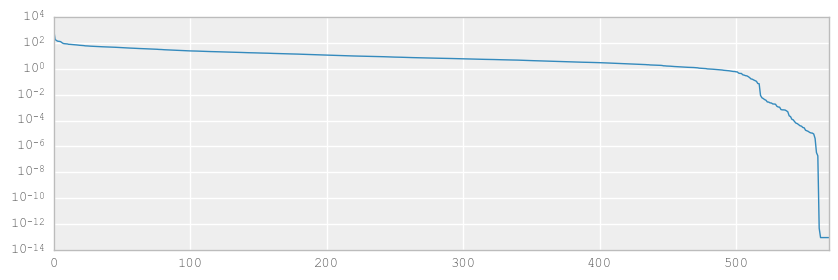

In [16]:
ax = pd.Series(s).plot(figsize=(10,3), logy=True)
print('{} SVs are NaN'.format(np.isnan(s).sum()))
print('{} SVs are less than 1e-12'.format(len(s[s< 1e-12])))

In [17]:
print(type(s))
np.size(s)

<class 'numpy.ndarray'>


569

##### Observe:
    + We seem to have some degeneracy in the data which is means the dataset is not so well-behaved. However, looking at the size of the singular value ndarray (which is 569), having zero NaN SVs and only 8 less than 1e-12 SVs still gives us confidence to move ahead with the dataset.

#### View Explained Variance

Variance preserved by first 300 components == 99.43%
Variance preserved by first 50 components == 76.48%


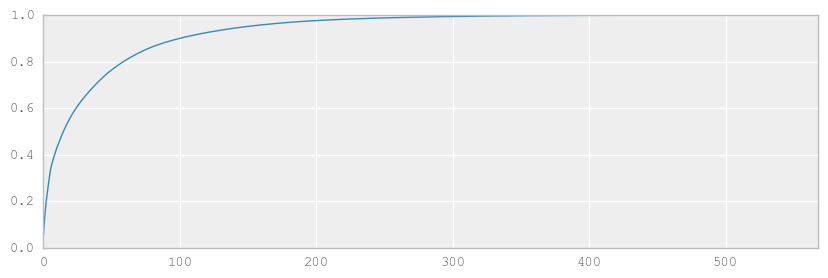

In [18]:
idx = ~np.isnan(s)
xtrans = np.dot(u[:,idx], np.diag(s[idx]))
expvar = np.var(xtrans, axis=0)
fullvar = np.var(df_normalized, axis=0)
expvarrat = expvar/fullvar.sum()
ax = pd.Series(expvarrat.cumsum()).plot(kind='line', figsize=(10,3))
print('Variance preserved by first 300 components == {:.2%}'.format(expvarrat.cumsum()[300]))
print('Variance preserved by first 50 components == {:.2%}'.format(expvarrat.cumsum()[50]))

##### Observe:

+ Surprisingly, it seems like we can compress the 568 original features into 300 components (eigenvectors) with only 0.57% loss of variance! There's clearly some near-degeneracy in the data (we got a hint of this when we found that therea are 8 SV < 1e-12).
+ If we get really extreme, we could consider representing the dataset using only the first 50 components and still maintain ~61% of the variance.

> We'll use SVD to reduce the dataset slightly - removing near-degeneracy, trying to preserve variance and thus replicating what we might do in the real-world prior to running machine learning algorithms such as CART and clustering etc.

## Dimentionality Reduction  using `scikit-learn` `TruncatedSVD` method

We are using the `TruncatedSVD` method in the `scikit-learn` package (Truncated-SVD is a [quicker calculation](https://en.wikipedia.org/wiki/Singular_value_decomposition#Reduced_SVDs), and using `scikit-learn` is more convenient and consistent with our usage elsewhere) to transform the full dataset into a representation using the top 300 components, thus preserving variance in the data but using fewer dimensions/features to do so. This has a similar effect to [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) where we represent the original data using an orthogonal set of axes rotated and aligned to the variance in the dataset.

_**Note:**_ we are using 300 as the number of features in the reduction process because it's just a nice round number(!) which preserves a lot of variance (~99%) and is still too large to easily visualise, necessitaing the use of t-SNE.

Variance preserved by first 300 components == 88.40%


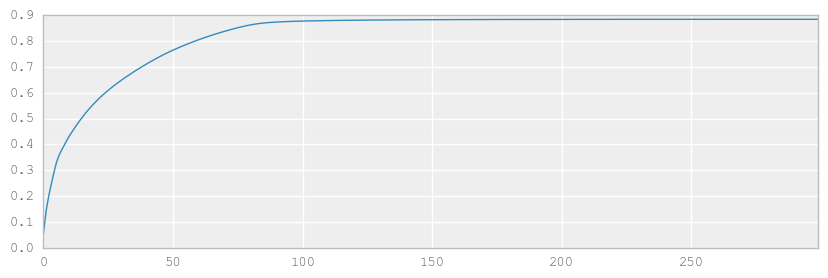

In [19]:
ncomps = 300
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(df_normalized)
Y = svd.fit_transform(df_normalized)
ax = pd.Series(svd_fit.explained_variance_ratio_.cumsum()).plot(kind='line', figsize=(10, 3))
print('Variance preserved by first 300 components == {:.2%}'.format(svd_fit.explained_variance_ratio_.cumsum()[-1]))


##### Observe:
+ We can preserve 88.40% variance by using just 300 components rather than the full 568 original features. This is a really useful compression, removing degeneracy and allowing all downstream analyses / algorithms to be faster whilst retaining useful information.

> For convenience, we'll create a dataframe specifically for these top 300 components.

In [20]:
dfsvd = pd.DataFrame(Y, columns=['c{}'.format(c) for c in range(ncomps)], index=df.index)
print(dfsvd.shape)
dfsvd.head()

(12083, 300)


,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c290,c291,c292,c293,c294,c295,c296,c297,c298,c299
0,10.948964,-2.553164,-1.320175,-0.332661,0.411241,-0.718791,-1.201730,0.928392,-1.340734,0.000102,...,-0.009889,0.052350,-0.032075,0.048414,0.021078,0.003820,0.067716,0.070925,0.003938,0.056920
1,9.884151,0.755475,0.712976,-1.156621,-0.582364,-0.396438,1.278687,-0.521558,0.136857,-0.009537,...,-0.005792,-0.001495,0.003062,0.003746,0.019787,-0.023426,0.003037,0.012957,-0.018053,-0.008156
2,7.234780,3.243273,1.911465,-1.155650,-0.881678,-0.965844,-1.188895,-0.130988,0.739993,-0.311070,...,0.002418,-0.009492,0.008908,-0.001142,-0.013537,-0.001148,-0.016739,-0.000538,-0.000425,0.002618
3,10.251207,-1.116670,-0.160277,-1.019178,0.248752,0.372991,-0.089328,1.095071,0.206726,0.678966,...,-0.006874,-0.017270,0.012730,0.022458,0.015250,0.017820,-0.009058,-0.004443,-0.010003,-0.015060
4,9.003233,0.464212,1.791192,0.851937,-0.460342,-1.239563,-0.011559,-0.362742,-0.680140,1.381440,...,0.011094,0.003730,0.013190,0.000048,0.003328,0.002470,0.000324,0.024120,-0.004930,0.002107


#### Write to DB

In [21]:
dfsvd.to_sql('df_svd',cnx,if_exists='replace', index=None)

---

---

# Basic Visualisation of Reduced Features

Lets attempt to visualise the data with the compressed dataset, represented by the top 300 components of an SVD.

In [22]:
dfsvd = pd.read_sql('select * from df_svd', cnx)
svdcols = [c for c in dfsvd.columns if c[0] == 'c']

df = pd.read_sql('select * from df_clean', cnx)

## Pairs Plots

Pairs-plots are a simple representation using a set of 2D scatterplots, plotting each component against another component, and coloring the datapoints according to their classification (Type of housing units: TYPEHUQ).

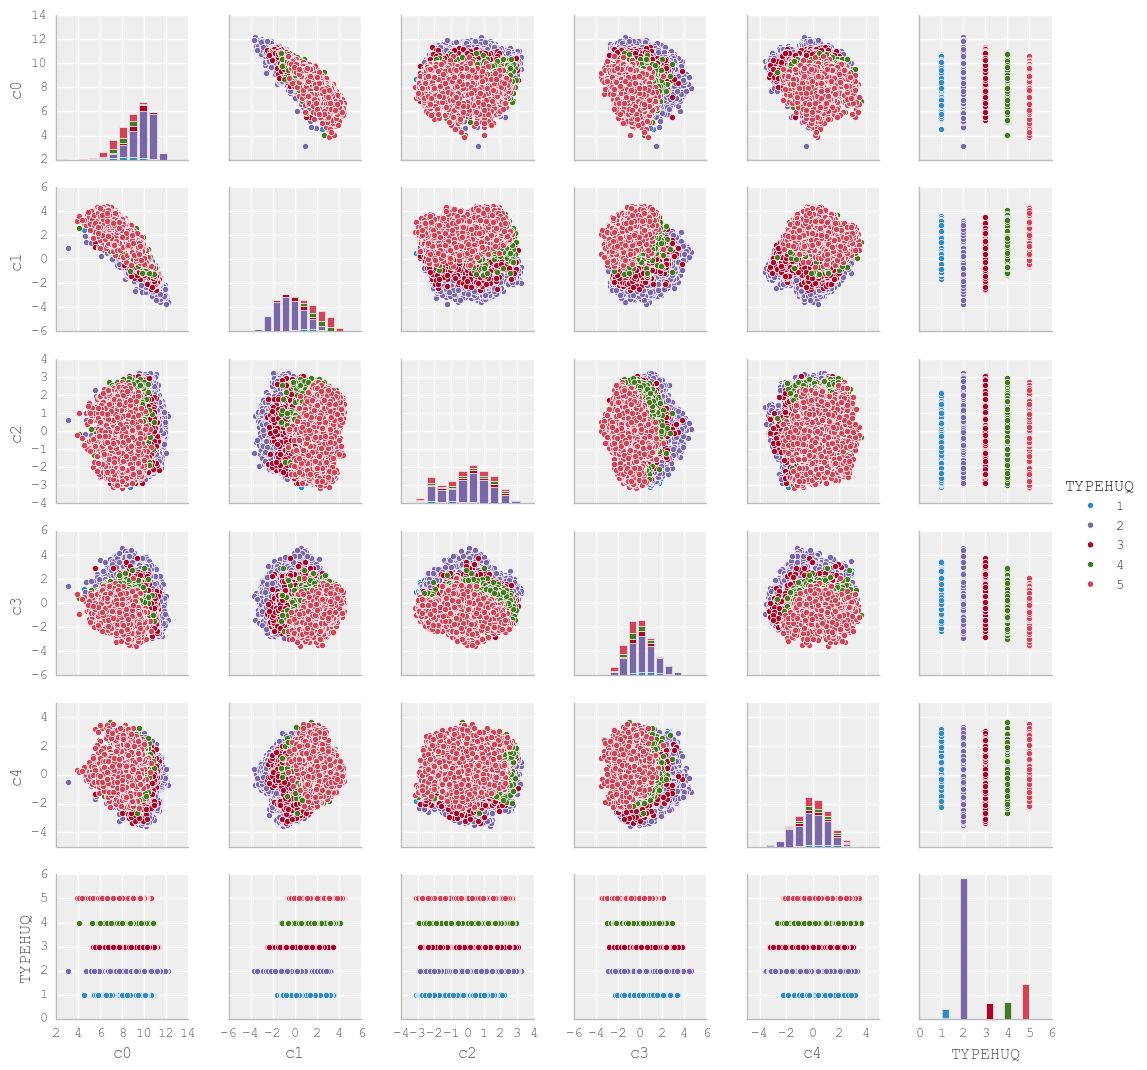

In [23]:
plotdims = 5
ploteorows = 1
dfsvdplot = dfsvd[svdcols].iloc[:,:plotdims]
dfsvdplot['TYPEHUQ']=df['TYPEHUQ']
ax = sns.pairplot(dfsvdplot.iloc[::ploteorows,:], hue='TYPEHUQ', size=1.8)

##### Observe:

+ We can clearly see that datapoints from the same type of housing units tend to cluster together
+ It's possible to see distinct TYPEHUQs on different sides of the plots, e.g.
    + `TYPEHUQ 2` and `TYPEHUQ 5` seem to predominate hidding away the information related to other TYPEHUQs
+ However, this pairs-plot suffers several issues for visualisation:
    + It shows only the first 5 components of the available 300, meaning we only see a small percentage of the full variance
    + If we try to show more components, the overall plot will get very large.
    + It's hard to get a full appreciation of the differences and similarities between datapoints across all the components, requiring that the reader hold comparisons in their head while viewing
    + Classes with lower counts e.g. `TYPEHUQ 1`, `TYPEHUQ 3` and `TYPEHUQ 4` are really hard to see


## 3D Scatterplot

As an alternative to the pairs-plots, we could view a 3D scatterplot, which at least lets us see more dimensions at once and possibly get an interactive feel for the data

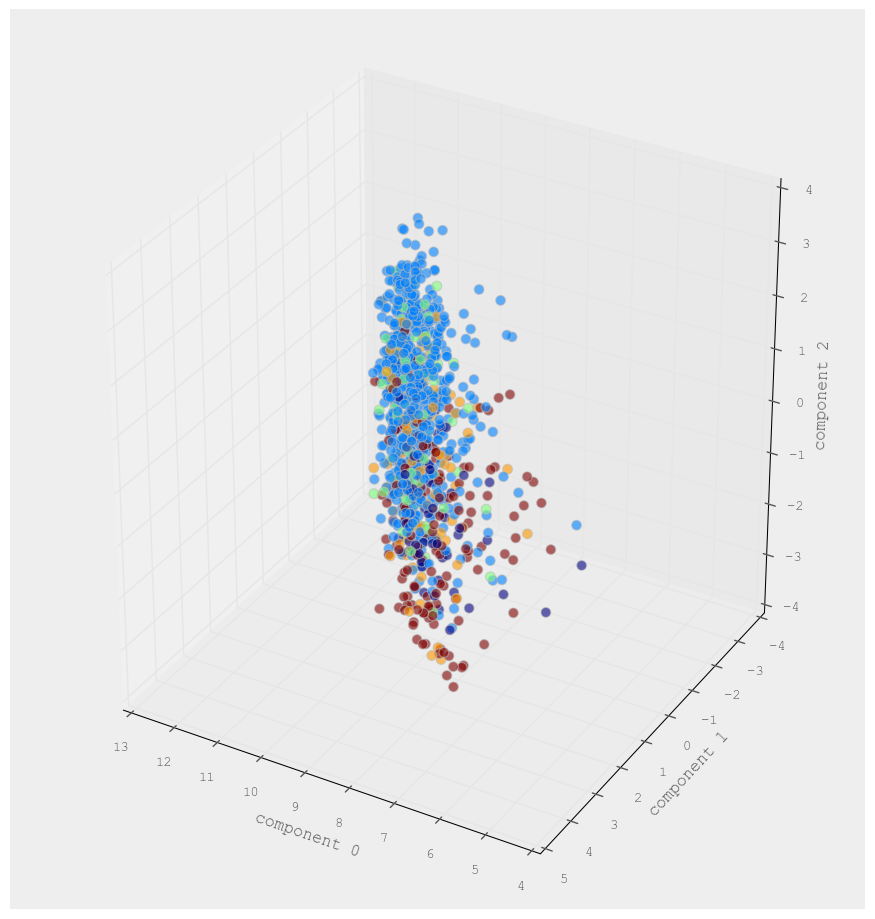

In [24]:
dfsvd['TYPEHUQ'] = df['TYPEHUQ']
interactive(scatter_3D, A=fixed(dfsvd), elevation=30, azimuth=120)

##### Observe:
+ The iPython Notebook interactive package lets us create an interactive plot with controls for elevation and azimuth
+ We can use these controls to interactively change the view of the top 3 components and investigate their relations. This certainly appears to be more informative than pairs-plots.
+ However, we still suffer from the same major limitations of the pairs-plots, namely that we lose a lot of the variance and have to hold a lot in our heads when viewing.

> We clearly need a better way to visualise the ~12000 datapoints and their 300 dimensions

---

---

## t-SNE visualization

Finally we're ready for the entree of this Notebook: t-SNE Manifold Learning.

t-SNE is a technique for probabilistic dimensionality reduction, developed within the last 10 years and with wider reception in the last 2-3 years, lots of detail at https://lvdmaaten.github.io/tsne/.

We will use the basic implementation available in `scikit-learn` which has O(n^2) complexity. Ordinarily this prohibits use on real-world datasets (and we would instead use the Barnes-Hut implementation O(n*log(n))), but for out 675 datapoints it's no problem. 

> We will, however, quickly demonstrate the scaling issue:

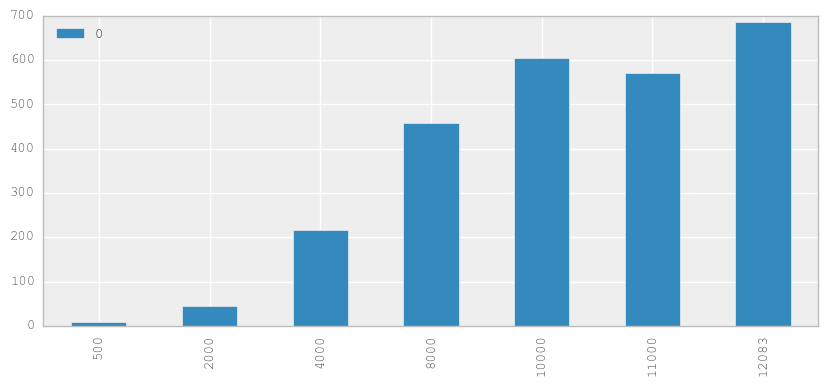

In [25]:
rowsubset = [500,2000,4000,8000,10000,11000,12083]
tsne = TSNE(n_components=2, random_state=0)
runs = np.empty((len(rowsubset),1))

for i, rows in enumerate(rowsubset):
    t0 = time()
    Z = tsne.fit_transform(dfsvd.iloc[:rows,:][svdcols])
    runs[i] = time() - t0

ax = pd.DataFrame(runs, index=rowsubset).plot(kind='bar', logy=False, figsize=(10,4))

##### Observe
+ As we anitcipate, we see that basic t-SNE scales badly O(n^2)
+ However, this dataset is of manageable size and calculation is quick on my laptop, so I won't use the faster Barnes-Hut implementation O(n*log(n))

## Calculate t-SNE representation

Firstly we'll calcualte the t-SNE 2D representation for our 300D dataset, and view the results without coloring the classes.

In [26]:
Z = tsne.fit_transform(dfsvd[svdcols])
dftsne = pd.DataFrame(Z, columns=['x','y'], index=dfsvd.index)

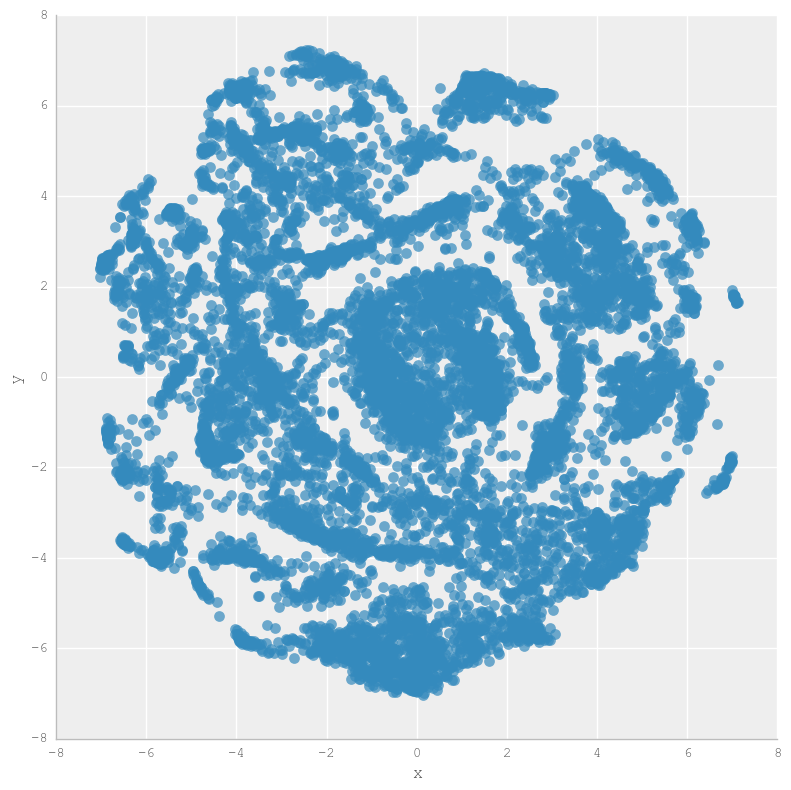

In [27]:
ax = sns.lmplot('x', 'y', dftsne, fit_reg=False, size=8
                ,scatter_kws={'alpha':0.7,'s':60})

##### Observe:
+ This seems promising. we've reduced our top 300 SVD components to 2 dimensions and we can clearly see clusters of datapoints.
+ When doing unsupervised learning (without class labels) we might expect to get this far and then backtrack to run clustering algorithms in the 300 dimensional space.


> Now let's view the t-SNE representation with TYPEHUQ classification class labels...

## View t-SNE representation with class labels

In [28]:
dftsne['TYPEHUQ'] = df['TYPEHUQ']        

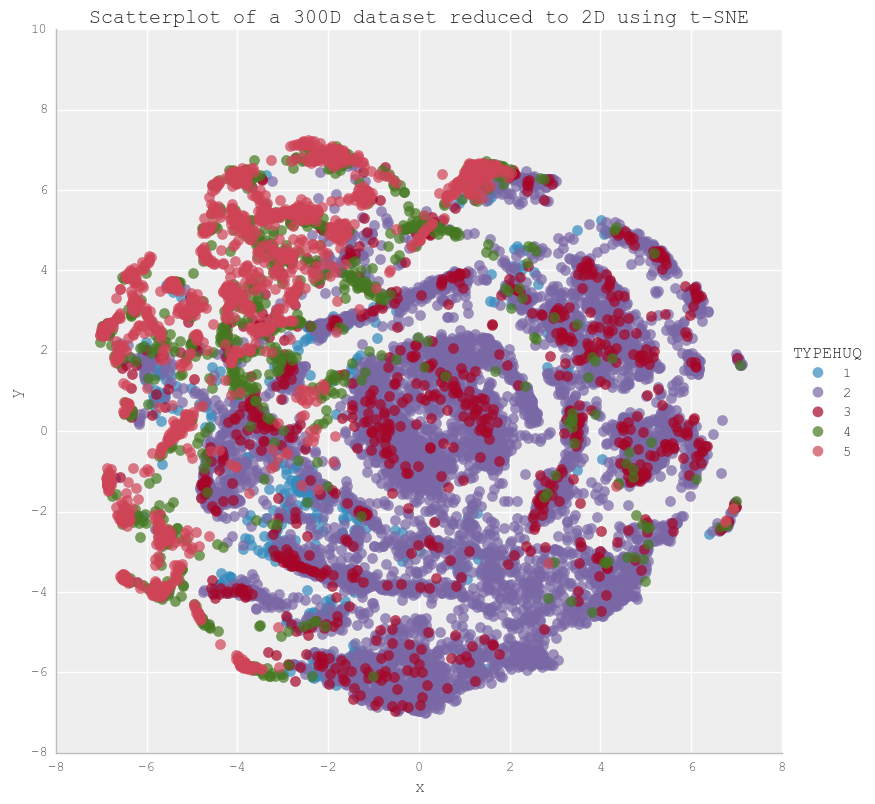

In [29]:
g = sns.lmplot('x', 'y', dftsne, hue='TYPEHUQ', fit_reg=False, size=8
                ,scatter_kws={'alpha':0.7,'s':60})
g.axes.flat[0].set_title('Scatterplot of a 300D dataset reduced to 2D using t-SNE')

##### Observe:

This is quite interesting way of visualizing the RECS data. The above plot shows us that the type of housing unit alone doesn't classify/categorize the households for their energy consumption patterns. Nonetheless, there is a good degree of clustering for Type 2 (purple) and Type 5 (Pink) houses. 

# In Review

We have analyzed the RECS 2009 dataset in the following steps:
+ We read from and wrote to different file format (csv) and databases (sql)
+ We prepared the data by cleaning (removing character features values, replacing nans) and normalizing.
+ We applied transformation during the feature reduction stage.
+ We then visualized the data in the reduced dimentionality and ultimately applied t-SNE algorithm to reduce the data into two dimensions and visualize effectivly